# Analyzing nightly housing situations

This is the cohort of people who constantly come back for a nightly stay.

In [1]:
import pandas as pd
import numpy as np

In [2]:
enrollment = pd.read_csv("data/preprocessed/enrollment_nightly_housing.csv", index_col=0)

In [3]:
enrollment.head()

,Personal ID,Project Entry ID,Client Age at Entry,Last Permanent Zip,Project Entry Date Updated,Destination,Entry Date,Exit Date,Project ID,Housing Status @ Project Start,...,Months Homeless This Time,Chronic Homeless,In Permanent Housing,Residential Move In Date,Domestic Violence Victim,DV When Occurred,DV Currently Fleeing,Super Project,UTC Entry Time,UTC Exit Time
1,173781,314080,35.0,93907,1/12/2015,"Emergency shelter, including hotel or motel pa...",2014-05-06,2014-09-30,2101,Category 1 - Homeless (HUD),...,NaN,No,NaN,NaN,Yes (HUD),From six to twelve months ago (HUD),NaN,Nightly Housing,1399359600,1.412060e+09
3,173782,314084,10.0,93905,1/7/2015,"Emergency shelter, including hotel or motel pa...",2014-05-06,2014-09-30,2101,Category 1 - Homeless (HUD),...,NaN,No,NaN,NaN,Yes (HUD),From six to twelve months ago (HUD),NaN,Nightly Housing,1399359600,1.412060e+09
5,173783,314085,12.0,93905,1/7/2015,"Emergency shelter, including hotel or motel pa...",2014-05-06,2014-09-30,2101,Category 1 - Homeless (HUD),...,NaN,No,NaN,NaN,Yes (HUD),From six to twelve months ago (HUD),NaN,Nightly Housing,1399359600,1.412060e+09
7,173803,201286,32.0,93905,4/27/2013,"Staying or living with family, temporary tenur...",2013-02-08,2013-04-27,2101,Category 1 - Homeless (HUD),...,NaN,No,NaN,NaN,Yes (HUD),From six to twelve months ago (HUD),NaN,Nightly Housing,1360310400,1.367046e+09
8,173804,201288,11.0,93905,4/27/2013,"Staying or living with family, permanent tenur...",2013-02-08,2013-04-27,2101,Category 1 - Homeless (HUD),...,NaN,No,NaN,NaN,No (HUD),NaN,NaN,Nightly Housing,1360310400,1.367046e+09


# Some questions

1. Can we find the average stay of a person?
2. How many times have people frequented the nightly stay?
3. Has there been trending changes over time?

## Quick statistics: How many times have people frequented the nightly stay?

In [7]:
personal_ids = enrollment["Personal ID"].tolist()

from collections import Counter

times_visited = Counter()
for pid in personal_ids:
    times_visited[pid] += 1

## Convert into a series
times_visited = pd.Series(times_visited)

In [8]:
times_visited.sort_values(ascending=False, inplace=True)

In [9]:
times_visited.describe()

count    5483.000000
mean        8.174722
std        26.155021
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       574.000000
dtype: float64

From the get-go, the data doesn't seem very trustworthy...

# Categorical distribution of the times visited

In [31]:
distribution = times_visited.value_counts()
distribution.sort_index(inplace=True)

In [32]:
# Saturate the distribution, so "0" appears when we don't get a count
max_value = distribution.index.max()
missing = {i for i in xrange(1, max_value + 1)}
missing = missing.difference(distribution.index)

In [34]:
missing = pd.Series(data=[0]*len(missing), index=list(missing))

In [35]:
missing

80     0
91     0
94     0
100    0
104    0
116    0
122    0
124    0
125    0
126    0
131    0
135    0
136    0
140    0
141    0
145    0
151    0
152    0
153    0
154    0
156    0
157    0
159    0
160    0
161    0
163    0
164    0
167    0
168    0
169    0
      ..
544    0
545    0
546    0
547    0
548    0
549    0
550    0
551    0
552    0
553    0
554    0
555    0
556    0
557    0
558    0
559    0
560    0
561    0
562    0
563    0
564    0
565    0
566    0
567    0
568    0
569    0
570    0
571    0
572    0
573    0
dtype: int64

In [40]:
distribution = distribution.append(missing)
distribution = distribution.sort_index()

In [25]:
import matplotlib.pyplot as plt

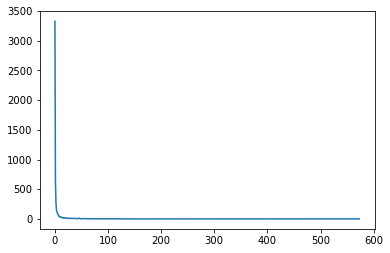

In [42]:
%matplotlib inline
plt.plot(np.arange(len(distribution)), distribution)

Okay so maybe this isn't very conductive. Let's remove the first `N` entries and see what happens...

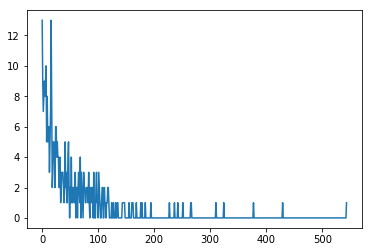

In [49]:
%matplotlib inline
n_subtracted = 30
plt.plot(np.arange(len(distribution) - n_subtracted), distribution[n_subtracted:])

## Plot only the 25th - 75th percentile

Shit this is gonna be a bitch to calculate right. `Series.distribution` isn't 

In [51]:
distribution.quantile([.25, .75])

0.25    0.0
0.75    1.0
dtype: float64

Okay that's a pretty shitty estimation. Let's instead remove any entries with zero.

In [56]:
non_zero_dist = distribution[~(distribution == 0)]

In [57]:
non_zero_dist.quantile([.25, .75])

0.25    1.00
0.75    6.25
dtype: float64